<a href="https://colab.research.google.com/github/kombalyn/vision/blob/master/EvaluateOnBreathsetWithDeepFlow3(PCA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/")

Mounted at /content/drive


In [2]:
from importlib.machinery import SourceFileLoader
methods = SourceFileLoader('methods', '/content/drive/My Drive/methods.py').load_module()

In [3]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import h5py

from methods import AverageSmooth
from methods import RMSE
from methods import CrossCorrelation
from methods import calcFurierTransform
from methods import MAE
from methods import wBasedPearson

TensorFlow 1.x selected.


# Definitions

In [4]:
wd = 200
FPS = 20

In [5]:
'''
Load in signal from file
'''
def readFromFile(path,filename,signal):
  print("Save to this file:"+path+filename)
  print("...")
  print("saved")
  with open(path+filename,"r") as ins:
    lines = ins.readlines()
    for line in lines:
      signal.append(float(line))
  return np.asarray(signal)

In [6]:
'''
save signal to file
'''
def saveToFile(path,filename,signal):
  print("Save to this file:"+path+filename)
  print("...")
  print("saved")
  with open(path+filename,"w") as o:
    for i in range(len(signal)):
      o.write(str(signal[i]))
      o.write("\n")

In [7]:
def loadSignalSet(path,set):
  ujset = []
  with open(path,'r') as ins:
    lines = ins.readlines()
    for line in lines:
      values = line.split(',')
      values = values[:-1] # At the end we have an extra ','
      row = []
      for val in values:
        row.append(float(val))
      ujset.append(row)
  return np.asarray(ujset)

In [8]:
def makeTresholdCurve(sig,division):
    tresholds = []
    for i in range(0,len(sig),division):
        window = sig[i:(i+division)]
        act_avg = np.average(window)
        for j in range(division):
            tresholds.append(act_avg)
    return tresholds

def tresholdByCurve(sig,tresholds,division,avg):
    newsig = []
    for i in range(0,len(sig),20):
        window = sig[i:(i+20)]
        trh = tresholds[i+10]
        window[window<trh] = avg
        newsig.append(np.asarray(window))
    newsig = np.asarray(newsig)
    newsig = newsig.flatten()
    sig = newsig
    return sig

def calcTreshold2(window,avg):
    upper = []
    for i in range(1,len(window)):
        if window[i-1]<=avg:
            if avg<window[i]:
                upper.append(i)
    return upper

def calcRate(sig):
    tresholds = makeTresholdCurve(sig,20)
    
    # Calculate avg:
    avg = np.average(sig)
    
    # treshold by the treshold curve:
    sig = tresholdByCurve(sig,tresholds,20,avg)
    
    # Binarization
    sig[avg<sig] = 1  
    sig[sig<avg] = avg
    
    # relative treshold set by avg:
    upper = calcTreshold2(sig,avg)

    return (len(upper)/(wd/FPS))*60

# Load Data

In [9]:
# '''
# Load the calculated signal
# '''
# signal=[]
# signal = loadSignalSet("output/MixedDataset3",signal)
# print(signal.shape)

In [10]:
# '''
# Load the calculated signal
# '''
# reference = []
# reference = readFromFile("output/","MixedDataset_ref3",reference)
# print(reference.shape)

In [11]:
'''
Load the calculated signal
'''
optflowsig = []
with  open("deepFlowPCA.txt","r") as ins:
  lines = ins.readlines()
  for line in lines:
    optflowsig.append(float(line))
#optflowsig = np.asarray(optflowsig)
optflowsig = np.asarray(optflowsig)

In [12]:
'''
Load the calculated signal
'''
refflow = []
with  open("reference.txt","r") as ins:
  lines = ins.readlines()
  for line in lines:
    refflow.append(float(line))
refflow = np.asarray(refflow)

99119
99121


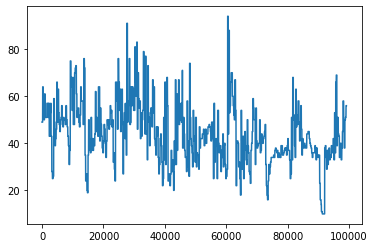

In [13]:
print(len(optflowsig))
print(len(refflow))
plt.plot(refflow)

In [14]:
def findLocalMaximas(sig,horizontal_treshold):
  places = []
  places.append(0)
  for i in range(1,len(sig)-1):
    if(sig[i-1]<sig[i] and sig[i+1]<sig[i]):
      if (horizontal_treshold<abs(i-places[-1])):
        places.append(i)
      else:
        if (sig[places[-1]]<sig[i]):
          places[-1]=i
  #places = places[1:]
  return np.asarray(places)

In [16]:
def diffRate(maxes):
  diffs = []
  for i in range(1,len(maxes)):
    diffs.append(maxes[i]-maxes[i-1])
  return (1.0/(np.mean(diffs)/20.0))*60.0

# Band Pass Filtering

In [17]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 20.0
lowcut = 1/6
highcut = 2

In [18]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [19]:
optflowsig = butter_bandpass_filter(optflowsig, lowcut, highcut, fs, order=6)

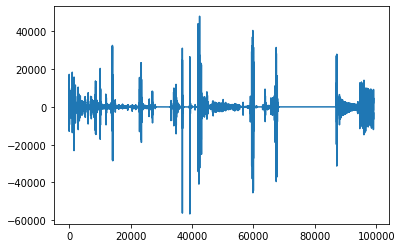

In [20]:
plt.plot(optflowsig)

# Reshape signals to [wd,wd]

In [21]:
signal = []
for i in range(0,len(optflowsig),200):
  seq = optflowsig[i:(i+200)]
  if (len(seq)==200):
    signal.append(seq)
signal = np.asarray(signal)
print(signal.shape)

(495, 200)


In [22]:
reference = []
for i in range(0,len(refflow),200):
  seq = refflow[i:(i+200)]
  if (len(seq)==200):
    reference.append(seq[100])
reference = np.asarray(reference)
print(reference.shape)

(495,)


In [23]:
signal = signal[:len(reference)]

In [24]:
print(signal.shape)

(495, 200)


# Demo

In [25]:
def mynorm(sig):
  avg = np.mean(sig)
  sig = sig - np.ones_like(sig)*avg
  sig = sig / np.max(sig)
  return sig

In [26]:
import time

In [ ]:
output_rates = []
refs = []
for i in range(0,len(signal)):
  sig = np.asarray(mynorm(signal[i]))
  sig = np.reshape(sig, [1,wd])
  t0= time.clock()
  maxes = findLocalMaximas(sig,8)
  #r =  diffRate(maxes)
  r =  calcRate(sig)
  t1 = time.clock()
  print("Time elapsed: ", t1 - t0) # CPU seconds elapsed (floating point)
  output_rates.append(r)
  refs.append(reference[i])

  #refs.append(np.mean(reference_train[i:i+wd]))

Time elapsed:  0.00025399999999997647
Time elapsed:  0.00023600000000101318
Time elapsed:  0.00026000000000081513
Time elapsed:  0.0002579999999987592
Time elapsed:  0.0002479999999991378
Time elapsed:  0.00027500000000024727
Time elapsed:  0.00023499999999998522
Time elapsed:  0.00025300000000072487
Time elapsed:  0.00024099999999904753
Time elapsed:  0.0002580000000005356
Time elapsed:  0.00023999999999979593
Time elapsed:  0.00027099999999968816
Time elapsed:  0.0002620000000010947
Time elapsed:  0.00022799999999989495
Time elapsed:  0.00025099999999866895
Time elapsed:  0.0002720000000007161
Time elapsed:  0.00023700000000026478
Time elapsed:  0.00029799999999902127
Time elapsed:  0.00035000000000096065
Time elapsed:  0.00031899999999929207
Time elapsed:  0.0003339999999987242
Time elapsed:  0.0003390000000003113
Time elapsed:  0.00030999999999892225
Time elapsed:  0.0003430000000008704
Time elapsed:  0.00037399999999898625
Time elapsed:  0.00025499999999922807
Time elapsed:  0.000

In [ ]:
print(len(output_rates))
print(len(refs))

495
495


In [ ]:
# absolute error
errors = []
for i in range(len(output_rates)):
  errors.append(abs(output_rates[i]-reference[i]))
print(np.mean(errors))

21.22222222222222


In [ ]:
output_rates = np.asarray(output_rates)
print(output_rates.shape)
print(reference[:300].shape)

(495,)
(300,)


In [ ]:
output_rates = output_rates.flatten()

In [ ]:
output_rates = np.reshape(output_rates, [len(output_rates)])

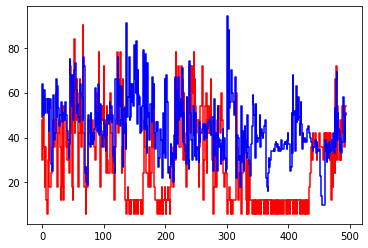

In [ ]:
plt.step(output_rates,'r')
plt.step(reference,'b')

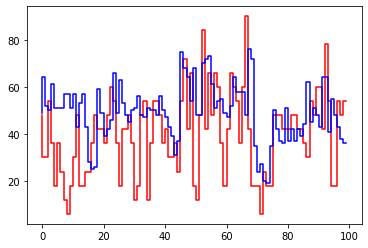

In [ ]:
plt.step(output_rates[:100],'r')
plt.step(reference[:100],'b')

In [ ]:
len_of_sliding_window = 1000

In [ ]:
ra = range(0,3000,len_of_sliding_window)

In [ ]:
for i in ra:
  print(i)

0
1000
2000


# On Selceted Region

In [ ]:
def mynorm(sig):
  avg = np.mean(sig)
  sig = sig - np.ones_like(sig)*avg
  sig = sig / np.max(sig)
  return sig

In [ ]:
import time

In [ ]:
output_rates = []
refs = []
for i in range(20,len(signal[:100])):
  sig = np.asarray(mynorm(signal[i]))
  sig = np.reshape(sig, [1,wd])
  t0= time.clock()
  r =  calcRate(sig)
  t1 = time.clock()
  print("Time elapsed: ", t1 - t0) # CPU seconds elapsed (floating point)
  output_rates.append(r)
  refs.append(reference[i])

  #refs.append(np.mean(reference_train[i:i+wd]))

Time elapsed:  0.0008410000000012019
Time elapsed:  0.0002290000000009229
Time elapsed:  0.0002170000000027983
Time elapsed:  0.00024700000000166256
Time elapsed:  0.0002290000000009229
Time elapsed:  0.0002729999999999677
Time elapsed:  0.00024700000000166256
Time elapsed:  0.00023600000000101318
Time elapsed:  0.00022099999999980469
Time elapsed:  0.00024700000000166256
Time elapsed:  0.00025300000000072487
Time elapsed:  0.0002540000000017528
Time elapsed:  0.0002519999999996969
Time elapsed:  0.00025299999999717215
Time elapsed:  0.00023999999999801958
Time elapsed:  0.0002519999999996969
Time elapsed:  0.0002460000000006346
Time elapsed:  0.00028700000000014825
Time elapsed:  0.0002309999999994261
Time elapsed:  0.0002480000000026905
Time elapsed:  0.00023799999999951638
Time elapsed:  0.00021999999999877673
Time elapsed:  0.00021800000000027353
Time elapsed:  0.0002809999999975332
Time elapsed:  0.0002400000000015723
Time elapsed:  0.00023499999999998522
Time elapsed:  0.00023799

In [ ]:
print(len(output_rates))
print(len(refs))

80
80


In [ ]:
# absolute error
errors = []
for i in range(len(output_rates)):
  errors.append(abs(output_rates[i]-refs[i]))
  #print(i,abs(output_rates[i]-reference[i]))
print(np.mean(errors))

14.625


In [ ]:
output_rates = np.asarray(output_rates)
print(output_rates.shape)
print(len(refs))

(80,)
80


In [ ]:
output_rates = output_rates.flatten()

In [ ]:
output_rates = np.reshape(output_rates, [len(output_rates)])

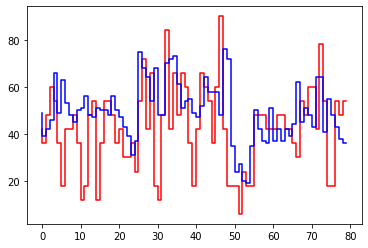

In [ ]:
plt.step(output_rates,'r')
plt.step(refs,'b')

#Numerical Evaluation

In [ ]:
import math

In [ ]:
# Normalize signal
def mynormalize(sig):
  avg = np.mean(sig)
  sig = sig - np.ones_like(sig)*avg
  sig = sig / np.max(sig)
  return sig

def myNorm(sig,ref):
    breathset2 = sig
    breathset1 = ref
    breathset1 = breathset1 - np.mean(breathset1)
    breathset2 = breathset2 - np.mean(breathset2)
    if (breathset1.size == 0):
        return None, None
    else:
        if (math.isnan(np.max(breathset1))):
            return None, None
        else:
            breathset1 = breathset1 / np.max(breathset1)
            breathset2 = breathset2 / np.max(breathset2)
            return breathset2, breathset1

RMSEs = []
MAEs = []
Coeffs =[]
for i in range(0,len(output_rates)-200,200):
    #sig_normed, ref_normed = myNorm(output_rates[i:(i+200)],reference[i:(i+200)])
    if (True):
        RMSEs.append(RMSE(output_rates[i:(i+200)],reference[i:(i+200)]))
        Coeffs.append(wBasedPearson(output_rates[i:(i+200)],reference[i:(i+200)]))
        MAEs.append(MAE(output_rates[i:(i+200)],reference[i:(i+200)]))

In [ ]:
print(np.mean(RMSEs))
print(np.mean(Coeffs))
print(np.mean(MAEs))

16.866912683537684
0.16245805058148022
11.9525


# Save evaluation

In [ ]:
saveToFile("output/","CalcRate-on-Breathset-2020-04-28",output_rates)
saveToFile("output/","CalcRate-on-Breathset-2020-04-28-ref",reference)

Save to this file:output/CalcRate-on-Breathset-2020-04-28
...
saved
Save to this file:output/CalcRate-on-Breathset-2020-04-28-ref
...
saved
